##### Copyright 2018 The TensorFlow Authors.

In [58]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [59]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Neural Network Classifier: Classifying Ar Descriptors

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a neural network model to classify Ar descriptors from solid, liquid and quenched xyz files.

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [60]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [61]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)

2.0.0


This guide uses the descriptors from differnet simulations of Ar atoms. The neural network learns to assign labels to unseen test descriptors based on the labelled training descriptors.

Here, 67,500 descriptos are used to train the network: 5,000 solid, 12,500 liquid and 50,000 misaligned quenched. 


In [62]:
train_input = np.load('train_input_soap(n_max=9)_misaligned_quench_solid_liquid.npy')
train_labels = np.load('train_input_soap(n_max=9)_misaligned_quenched_solid_liquids_labels.npy')
test_labels = np.load('test_input_liquid_labels.npy')
test_input = np.load('train_input_soap(n_max=9)_liquid.npy')

Loading the dataset returns four NumPy arrays:

* The `train_input` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_input`, and `test_labels` arrays.

The descriptors are in NumPy arrays. The *labels* are an array of integers, ranging from 0 to 1. These correspond to the *class* of atom the descriptor represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Liquid</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Solid</td>
  </tr>
</table>

Each descriptor is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later:

In [63]:
classifications = ['liquid', 'solid']

## Checking the format of input data is correct

Before training the neural network, the format of the data must be correct. The following shows there are 67,500 parameters in the training set.

In [64]:
train_input.shape

(67500, 316)

Likewise, there are 67,500 labels in the training set:

In [65]:
len(train_labels)

67500


Each label is an integer between 0 and 1:

In [66]:
train_labels

array([1., 1., 1., ..., 0., 0., 0.])

This checks if the number of inputs and labels are the same in the test set. 

In [67]:
test_input.shape

(50000, 316)

And the test set contains the same number of  descriptor labels:

In [68]:
len(test_labels)

50000

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. 

Most of machine learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [69]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

The network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first *ReLU* `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 2-node *softmax* layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the descriptor belongs to the 0 or 1 label class.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.

* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the descriptors that are correctly classified.

In [70]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_input` and `train_labels` arrays.
2. The model learns to associate descriptors and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_input` array. Verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—so called because it "fits" the model to the training data:

In [71]:
start1 = time.time()
model.fit(train_input, train_labels, epochs=10)
end1 = time.time()

print (end1-start1)

Train on 67500 samples
Epoch 1/10
67500/67500 [==============================] - 4s 54us/sample - loss: 0.1676 - accuracy: 0.9346
Epoch 2/10
67500/67500 [==============================] - 3s 46us/sample - loss: 0.0784 - accuracy: 0.9712
Epoch 3/10
67500/67500 [==============================] - 3s 46us/sample - loss: 0.0697 - accuracy: 0.9745
Epoch 4/10
67500/67500 [==============================] - 3s 45us/sample - loss: 0.0649 - accuracy: 0.9759
Epoch 5/10
67500/67500 [==============================] - 3s 44us/sample - loss: 0.0621 - accuracy: 0.9765
Epoch 6/10
67500/67500 [==============================] - 3s 47us/sample - loss: 0.0591 - accuracy: 0.9781
Epoch 7/10
67500/67500 [==============================] - 3s 46us/sample - loss: 0.0562 - accuracy: 0.9792
Epoch 8/10
67500/67500 [==============================] - 3s 45us/sample - loss: 0.0543 - accuracy: 0.9796
Epoch 9/10
67500/67500 [==============================] - 3s 44us/sample - loss: 0.0530 - accuracy: 0.9799
Epoch 10/10
67

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 100% on the training data after 10 epochs.

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [72]:
start = time.time()
test_loss, test_acc = model.evaluate(test_input,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
end = time.time()
print (end-start)

50000/1 - 1s - loss: 0.1648 - accuracy: 0.9155

Test accuracy: 0.91552
1.5911824703216553


The accuracy on the test dataset can often be a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting is when a machine learning model performs worse on new, previously unseen inputs than on the training data.

## Make predictions

With the model trained, you can use it to make predictions about some descriptors

In [73]:
start = time.time()
predictions = model.predict(test_input)
end = time.time()
print (end-start)

1.359675407409668


Here, the model has predicted the label for each descriptor in the testing set. This is the result of the first prediction:

In [74]:
predictions[0]

array([0.9758573 , 0.02414267], dtype=float32)

A prediction is an array of 2 numbers. They represent the model's "confidence" that the data is liquid (index [0]) or solid (index[1]). The 1 or 0 label is assigned to the descriptor for whichever index has the highest confidence value:

In [75]:
np.argmax(predictions[0])

0

So, if the model is most confident that the data is liquid, or `test_label[0]`. The 0 label will be assigned.

In [76]:
test_labels[0]

0.0

## Confidence Plots

In [77]:
x = predictions[:,0]


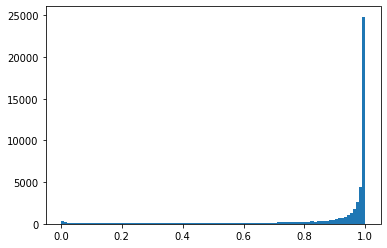

In [78]:
plt.hist(x, bins = 100)
plt.show()

This confidence plot shows the models overall confidence that the test data is liquid and should be labelled 0.

In [79]:
x = predictions[:,1]

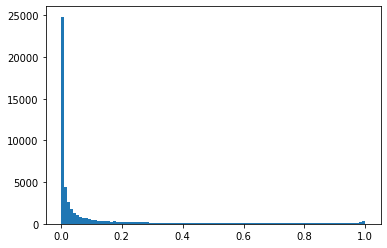

In [80]:
plt.hist(x, bins = 100)
plt.show()

This confidence plot shows the models overall confidence that the test data is solid and should be labelled 1.